# Harris and FAST Feature Detection

This notebook implements:

- Harris Corner Detection (with multi-scale and sub-pixel refinement)
- FAST Corner Detection (with score-based Non-Maximum Suppression)

Both detectors are applied to an input image and compared visually.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, uniform_filter, maximum_filter


In [ ]:
# Harris Code Computation
def harris_response(gray, block_size=3, k=0.04):
    gray = gray.astype(np.float32)

    Ix = sobel(gray, axis=1, mode='reflect')
    Iy = sobel(gray, axis=0, mode='reflect')

    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    Ixx = gaussian_filter(Ixx, sigma=1)
    Iyy = gaussian_filter(Iyy, sigma=1)
    Ixy = gaussian_filter(Ixy, sigma=1)

    Sxx = uniform_filter(Ixx, size=block_size)
    Syy = uniform_filter(Iyy, size=block_size)
    Sxy = uniform_filter(Ixy, size=block_size)

    detM = Sxx * Syy - Sxy * Sxy
    traceM = Sxx + Syy

    R = detM - k * (traceM ** 2)
    return R


In [ ]:
#Harris NMS + Threshold
def harris_nms(R, radius=1):
    max_R = maximum_filter(R, size=2*radius+1)
    return (R == max_R)

def harris_threshold(R, percentile=99.0):
    R_pos = R[R > 0]
    if R_pos.size == 0:
        return np.zeros_like(R, dtype=bool)
    t = np.percentile(R_pos, percentile)
    return (R > t)

def harris_detect_points(R, nms_radius=1, percentile=99.0):
    mask_thresh = harris_threshold(R, percentile=percentile)
    mask_nms = harris_nms(R, radius=nms_radius)
    mask = mask_thresh & mask_nms

    ys, xs = np.nonzero(mask)
    return list(zip(ys, xs))


In [ ]:
#Subpixel Refinement
def harris_refine_subpixel(R, corners):
    refined = []
    h, w = R.shape

    for y, x in corners:
        y = int(y)
        x = int(x)

        if y <= 0 or y >= h-1 or x <= 0 or x >= w-1:
            refined.append((float(y), float(x)))
            continue

        patch = R[y-1:y+2, x-1:x+2]

        dy = np.array([-1, 0, 1])
        dx = np.array([-1, 0, 1])
        Y, X = np.meshgrid(dy, dx, indexing='ij')

        A = np.column_stack([
            X.ravel()**2,
            Y.ravel()**2,
            X.ravel()*Y.ravel(),
            X.ravel(),
            Y.ravel(),
            np.ones_like(X.ravel())
        ])

        b = patch.ravel()
        coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        a, b2, c, d, e, f0 = coeff

        M = np.array([[2*a, c],
                      [c, 2*b2]])
        g = np.array([-d, -e])

        try:
            offset = np.linalg.solve(M, g)
            dx_sub, dy_sub = offset

            if abs(dx_sub) <= 1 and abs(dy_sub) <= 1:
                refined.append((y + dy_sub, x + dx_sub))
            else:
                refined.append((float(y), float(x)))

        except np.linalg.LinAlgError:
            refined.append((float(y), float(x)))

    return refined


In [ ]:
#Multi-Scale Harris
def gaussian_pyramid(gray, num_levels=3, sigma=1.0):
    images = [gray.astype(np.float32)]
    for i in range(1, num_levels):
        blurred = gaussian_filter(images[-1], sigma=sigma)
        down = cv2.pyrDown(blurred.astype(np.float32))
        images.append(down)
    return images


In [ ]:
#FAST Detector
def fast_score(gray, y, x, circle, threshold):
    center = int(gray[y, x])
    score = 0
    for dx, dy in circle:
        p = int(gray[y + dy, x + dx])
        diff = abs(p - center)
        if diff > threshold:
            score += diff
    return score


In [ ]:
#FAST Detection + NMS
def fast_corners_with_scores(gray_img, threshold=25, n=12):
    if gray_img.dtype != np.uint8:
        gray = gray_img.astype(np.uint8)
    else:
        gray = gray_img

    h, w = gray.shape
    corners = []
    scores = []

    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1),
        (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1),
        (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            center = int(gray[y, x])

            consec_bright = consec_dark = 0
            max_consec_b = max_consec_d = 0

            for dx, dy in circle:
                p = int(gray[y + dy, x + dx])

                if p > center + threshold:
                    consec_bright += 1
                    consec_dark = 0
                    max_consec_b = max(max_consec_b, consec_bright)

                elif p < center - threshold:
                    consec_dark += 1
                    consec_bright = 0
                    max_consec_d = max(max_consec_d, consec_dark)

                else:
                    consec_bright = 0
                    consec_dark = 0

            if max_consec_b >= n or max_consec_d >= n:
                s = fast_score(gray, y, x, circle, threshold)
                corners.append((y, x))
                scores.append(s)

    return corners, np.array(scores)


In [ ]:
#Run Pipeline

def run_pipeline_on_image(img_path):
    original = cv2.imread(img_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    R = harris_response(gray)
    corners = harris_detect_points(R)

    fast_pts, fast_scores = fast_corners_with_scores(gray)

    img_harris = original.copy()
    for (y, x) in corners:
        cv2.circle(img_harris, (x, y), 3, (0, 0, 255), -1)

    img_fast = original.copy()
    for (y, x) in fast_pts:
        cv2.circle(img_fast, (x, y), 3, (0, 255, 0), -1)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.title("Harris Corners")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.title("FAST Corners")
    plt.axis("off")

    plt.show()



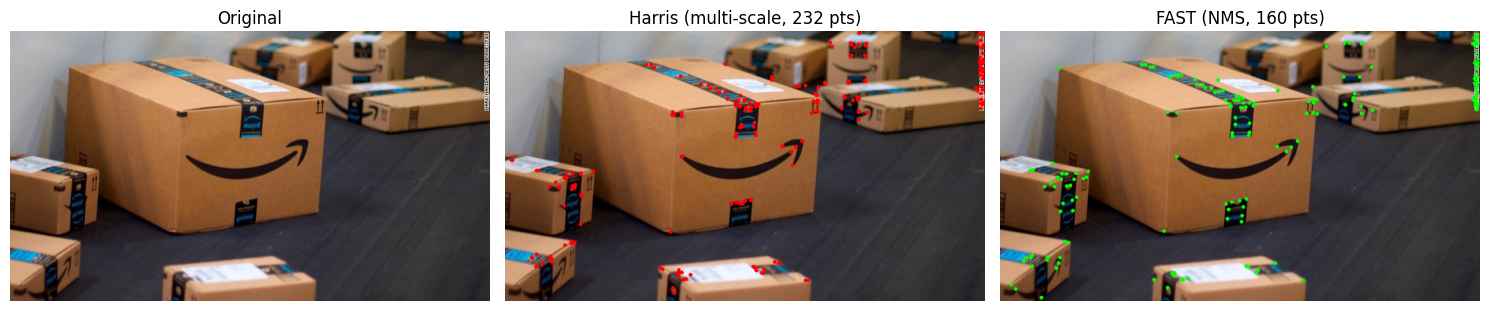

In [ ]:
run_pipeline_on_image("amazon.jpg")